# GPz_Pype: How-to for the basic features and usage

In [1]:
import numpy as np

# Plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Astropy modules
from astropy.table import Table, join, vstack, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import binom_conf_interval
# Import required gpz_pype functions
from gpz_pype.utilities import Params, set_gpz_path, basic_lupt_soft, flux_to_lupt
from gpz_pype.base import GPz
from gpz_pype.gmm import GMMbasic,kl_score
from numpy.ma import masked
# # Other modules - might not be required
# import subprocess
# import pickle

def calcStats(photoz, specz):
    cut = np.logical_and(photoz >= 0, specz >= 0.)
    #print('NGD: {0}'.format(cut.sum()))
    dz = photoz - specz
    abs_dz = np.abs(dz)/(1+specz)

    p90 = (abs_dz < np.percentile(abs_dz, 90.))
    sigma_90 = np.sqrt(np.sum((dz[p90]/(1+specz[p90]))**2) / float(len(dz)))

    bias = np.nanmedian(dz[cut]/(1+specz[cut]))
    ol1 = (abs_dz > 0.15)
    nmad = 1.48 * np.median( np.abs(dz[cut] - np.median(dz[cut])) / (1+specz[cut]))
    ol2 = (abs_dz > (3*nmad))
    OLF1 = np.sum( ol1[cut] ) / float(len(dz[cut]))
    OLF2 = np.sum( ol2[cut] ) / float(len(dz[cut]))
    
    ol1_s, ol2_s = np.invert(ol1), np.invert(ol2)

    return nmad, sigma_90, OLF1, bias

def useLatex():
    plt.rcParams.update({
        "text.usetex":True,
        "font.family":"lmodern",
        "text.latex.preamble":r"\usepackage{amsmath,amssymb}"})

In [2]:
#train=Table.read('MPhys/gpz_catalogues/bc_full_training_cat_new.cat', format='ascii')
#train=Table.read('MPhys/gmm_files/primer_only_train.fits', format='fits')
#t = Table.read('MPhys/gpz_catalogues/f435w_full_training_cat.cat',format ='ascii')
catalogue = Table.read('MPhys/gmm_files/f435w_luptitude_full_catalogue_new.fits',format='fits')

In [3]:
primer=np.zeros(len(catalogue))
for i in range(len(catalogue)):
    if catalogue['field'][i]=='cosmos_east' or catalogue['field'][i]=='cosmos_west':
        primer[i]=1
primer_good = np.array(primer, dtype=bool)        
train = catalogue[primer_good]       
train

field,id,ra,dec,z_spec,lupt_f435w,lupterr_f435w,lupt_f200w-clear,lupterr_f200w-clear,lupt_f356w-clear,lupterr_f356w-clear,lupt_f444w-clear,lupterr_f444w-clear
bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
cosmos_east,325130,150.14265971269515,2.159294885091907,--,27.63234125562078,0.38752653794817726,26.807566415670124,0.10491684027034777,27.091569256561066,0.08980318807824646,27.1648218827221,0.11088203934292074
cosmos_east,325186,150.14336680433422,2.159658169377521,--,29.32421147291766,0.6782072269482168,27.033123825883298,0.1317306537684567,26.947684725324436,0.0785835762176247,27.455640899031618,0.14648929941814917
cosmos_east,325255,150.14215846311578,2.1600553567486656,--,27.938566184246614,0.2721378448727768,27.123749113796187,0.14459754284290963,27.822335554412483,0.17979711124089787,28.325209187975556,0.3152167777571395
cosmos_east,325299,150.1418059794976,2.1604115513879347,--,27.796152743354387,0.2439294004369469,27.59223298406836,0.22688193366837758,28.6542551258556,0.36468134453448253,29.187938709667243,0.6056812652898728
cosmos_east,325312,150.1445419952084,2.1605026998904813,--,28.29748391549042,0.4909451613728463,27.52254024458854,0.20629476992023657,28.013726124184263,0.20949436140458294,28.408571235448914,0.33488317108173304
cosmos_east,325319,150.1411826680898,2.1603784574108627,--,27.951825482457238,0.26787492206611024,24.335197180320858,0.011365183343203846,24.089985672866288,0.006960981255069723,24.227199456365135,0.00849521643143458
cosmos_east,325320,150.14099021098056,2.1603616144949487,--,29.199988374754078,0.6416784112432016,25.417518911700874,0.030423949077406868,24.317677181245383,0.007850381774043605,24.093041798174543,0.00738737303761719
cosmos_east,325344,150.1402210670796,2.160685948396763,--,28.8158781582007,0.5968692505592783,27.2445840175759,0.15882986057029608,27.50459936089985,0.14305734278347565,27.59999584870679,0.17967694949699728
cosmos_east,325347,150.14290358860762,2.160697951091212,--,28.89077022036988,0.5556083318450692,26.400847676177797,0.0756404028588023,25.98040323076167,0.03557096511130361,26.478648621056738,0.059014808299685785


In [4]:
catalogue['z_spec'][catalogue['z_spec'] < 0] = np.ma.masked
cat=np.ones(len(catalogue))
for i in range(len(catalogue)):
    if np.ma.is_masked(catalogue['z_spec'][i]):
        cat[i]=0
cat_good = np.array(cat,dtype=bool)
catalogue=catalogue[cat_good]
catalogue

field,id,ra,dec,z_spec,lupt_f435w,lupterr_f435w,lupt_f200w-clear,lupterr_f200w-clear,lupt_f356w-clear,lupterr_f356w-clear,lupt_f444w-clear,lupterr_f444w-clear
bytes13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ceers,706,215.0364101057726,52.87110679174102,5.274,30.97919900448706,1.6616184682728519,29.052736495722804,0.19583433824861615,29.713718860688097,0.25274204660865474,29.87490544286587,0.32623040011658233
ceers,829,215.0356672831309,52.8713256478962,6.957,28.329601308473663,0.3248538858043344,27.74454881282078,0.06594927881022301,28.013792288471095,0.06333803104743128,28.315355567869364,0.12623766599756323
ceers,848,215.03602853363492,52.871708198965074,4.474,28.19602840840241,0.28476164047549446,25.657096464193604,0.010816909296956506,26.180332995545218,0.013503340406516079,26.188248496675683,0.019732304228555368
ceers,1434,215.14843144267866,52.95518523364641,1.2772,23.80585887247852,0.0063489341581104254,22.51918188803808,0.0015065599841071118,22.25019657550435,0.0012059248043021684,22.266863104770728,0.0014247739262403802
ceers,1902,215.03279448319276,52.8734274704991,1.6872,26.875925635563057,0.08972923305102991,22.1296299886604,0.0011961404501099249,21.753741116273513,0.0010338257194033038,21.61072033416943,0.0008905608993140332
ceers,1903,215.0326747096291,52.87382291417318,2.1614,26.545203202859337,0.0698007615539647,23.63925411476512,0.0026659801024458895,23.344419097914496,0.0023750827219524125,23.22619131410481,0.002184675206340201
ceers,1906,215.0333106230903,52.87264634932223,1.2304,24.955248897713815,0.01821762162369097,22.810077039872503,0.0016201273819285993,22.421816553880667,0.001310755030589732,22.435011280942717,0.0013680440287817141
ceers,2432,215.14029741564545,52.95248859554439,1.1664,25.285025105982044,0.6877421193994395,23.72090299213138,0.003247078928724681,23.543132706253502,0.0024694122459679147,23.675035952834218,0.0038292155739303433
ceers,2476,215.03099612358804,52.87437330968595,0.5762,26.471082882902248,0.0637814277775701,23.912618953300527,0.003088339663159895,24.246118374177836,0.010898425907379437,24.620536509198836,0.005635240137453824


For this example notebook we will use the CANDELS COSMOS catalogue as an input. This includes lots of photometry from both ground + space, but we will restrict analysis to just the HST filters for simplicity (and to mimic the likely limitations of some JWST fields).

Inputting the catalogue into GPz however requires some additional pre-processing. We start by extracting the general common columns and setting any missing `z_spec` values to `np.nan`:

To further trim the catalogue down, i next want to pull out only the flux/magnitude columns that belong to HST filters. In this case, columns that start with either 'ACS' or 'WFC'. As with `z_spec`, any value set as -99 in the input catalogue (i.e. no data) is converted to `np.nan`:

In [5]:
filters =[]
for col in train.colnames:
    if col.startswith('lupt_'):
        name = col.split('_')[1]
        filters.append(name.split('-')[0])# Split column name into 3 parts based on '_'

print(filters)

['f435w', 'f200w', 'f356w', 'f444w']


## Running GPz through `gpz_pype`

The following code assumes that `gpz++` is correctly installed on the system and that it can be run through the command line without issue. The `gpz_pype` classes simply wrap around `gpz++` and streamline the book-keeping required when using more complicated splitting+weighting of training sample.

The path to `gpz++` can be set as a system variable so this step might not be required in future. It can also be input directly into the `GPz` class below, but for safety we can use the convenience function `set_gpz_path` to set this for the current session.

In [6]:
set_gpz_path('MPhys/gpz_files/gpz++')


The main workhorse of `gpz_pype` is the `GPz` class, it needs to be instantiated with a set of parameters that we can then update manually (and which `GPz` will automatically set for us when necessary).
We can also define the number of CPUs we want `gpz++` to make use of during training:

In [7]:
test = GPz(param_file='gpz_jwst_bc_s.param', ncpu=4)

In [8]:
test.params['REUSE_MODEL'] = '0'

#test.params['OUTPUT_MAX']= '16'

To perform GPz training on an input catalogue in gpz++ in our most straight-forward approach, we can use the `.run_training` function from the `GPz` class.

Even in its most straight-forward approach, there are lots of options that must be set. Many of which can be left as their degault value. I have tried to ensure that in-code documentation for `gpz_pype` is relatively complete, so the full set of options available can be seen using the standard python help functionality, e.g.:

In [9]:
help(test)

Help on GPz in module gpz_pype.base object:

class GPz(builtins.object)
 |  GPz(param_file=None, gpz_path=None, ncpu=None)
 |  
 |  Class to run GPz.
 |  
 |  This class is used to prepare and run gpz++ on a given catalog.
 |  Options for running gpz++ are set in a parameter file, which can
 |  be read in using the read() method.  Alternatively, options can
 |  be set directly using the class attributes.
 |  
 |  The run_training() method can be used either to run gpz++ on a
 |  single catalogue, or to automatically split a catalogue into
 |  mixture samples for training and testing based on a given
 |  GMM model (see gpz_pype.gmm.GMMbasic).
 |  
 |  gpz++ can be called directly from within the class or for large
 |  catalogues, the necessary run commands can be written to a shell
 |  script.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, param_file=None, gpz_path=None, ncpu=None)
 |      Parameters
 |      ----------
 |      param_file : str, optional
 |          Path to param

# Set NBF 

In [10]:
n = 150

In [11]:
directory = 'MPhys/gmm_files/feature_permutations'

In [12]:
simple_run, paths = test.run_training(
      catalogue, # Run training on this input catalogue - can be a path or a Table object
      outdir=directory, # Save training/output catalogues in this directory
      basename=f'jwst_f435w', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt', # Look for these asinh magnitude columns
      error_prefix='lupterr', # Look for these error columns
      output_max = 16,
      id_col='id', # ID column to propagate into output files
      total_basis_functions=n, # NUMBF passed to gpz++
      do_iteration=False, # If True, run second iteration with more complex covariance
      verbose=True, # Don't print all of the gpz++ output to screen. Turn on for debugging
    )

There are two outputs from `.run_training`:

1. Catalogue: The 'test' subset of the input catalogue, with `gpz++` prediction columns appended:

2. Output paths: A dictionary containing the relative paths to the various files produced from the gpz++ training - including both input catalogues (in gpz format) and the trained model + associated parameter file:

In [13]:
paths

{'train': 'MPhys/gmm_files/feature_permutations/jwst_f435w_train.txt',
 'test': 'MPhys/gmm_files/feature_permutations/jwst_f435w_test.txt',
 'output_cat': 'MPhys/gmm_files/feature_permutations/jwst_f435w_output.txt',
 'output_model': 'MPhys/gmm_files/feature_permutations/jwst_f435w_model.dat',
 'param': 'MPhys/gmm_files/feature_permutations/jwst_f435w.param'}

### Plotting outputs
Just for validation purposes, lets plot the predicted photo-$z$ versus spec-$z$ for the test catalogue. We can see that between $1 < z < 3$ the predictions do a decent job, even with just the 4-bands used in training. But at low and high redshifts the performance falls off

<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


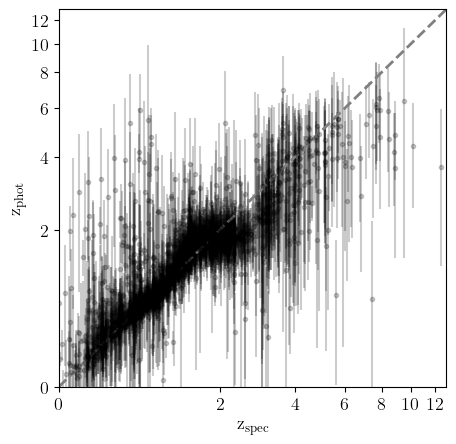

In [15]:
# Function x**(1/2)
def forward(x):
    return np.log10(1+x)

def inverse(x):
    return (10**x) - 1

Fig, Ax = plt.subplots(1,1,figsize=(5,5))
useLatex()
plt.rcParams.update({"font.size":13})
Ax.errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)
Ax.set_xlim([0, 13])
Ax.set_ylim([0, 13])
#
Ax.set_yscale('function', functions=(forward, inverse))
Ax.set_xscale('function', functions=(forward, inverse))


Ax.plot([0, 14], [0, 14], '--', color='0.5', lw=2)
Ax.set_xlabel(r'$\text{z}_{\text{spec}}$',fontsize=13)
Ax.set_ylabel(r'$\text{z}_{\text{phot}}$',fontsize=13)
plt.savefig(f'MPhys/gmm_files/feature_permutations/plots/f435w_simple.png', bbox_inches='tight')

## Example GMM Divide + Cost-sensitive Learning Calculations

The basic functionality for the Gaussian Mixture Model (GMM) sample division and cost-sensitive learning is contained in the `GMMbasic` class. The training of the respective GMMs is done internally within the class, and is effectively a wrapper around the [sci-kit learn/GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) classes with all its functionality.

The key inputs that we need to define for `GMMbasic` are as follows:

- `X_pop` : The feature array for the reference population.
- `X_train` : The feature array for the training sample.
- `Y_train` : The labels for the training sample (i.e. the spectroscopic redshifts).
- `ncomp` : Number of mixtures used for the GMM model.

For building the mixture models, we need to manually decide on and create a set of features (`X_pop`/`X_train`) with which we want to represent our sample. The 'best' features will be dependent on the input data, the scientific goals etc. These also do not necessarily need to be features used in the GPz training (e.g. luptitudes), or even things derived from luptitudes. 

In the following example, given the limited number of features we will just use a combination of colours and magnitudes. But sizes or morphological information could also be sensible choices.

Since for our example the training set is a subset of the reference population, we can define one set of features and then split:

In [16]:
filters=['f435w', 'f200w-clear', 'f356w-clear', 'f444w-clear']

In [17]:
check_nans = np.zeros(len(catalogue)) # Running counter of null values for each object
for i,filt in zip(range(len(catalogue)),filters):
    if np.ma.is_masked(catalogue[f'lupt_{filt}'][i]):
        check_nans[i]=1
good=(check_nans==0)

In [18]:
check_nans_train = np.zeros(len(train)) # Running counter of null values for each object
for i,filt in zip(range(len(train)),filters):
    if np.isnan(train[f'lupt_{filt}'][i]):
               check_nans_train[i]=1
good_train =(check_nans_train==0)
print(good_train)

[ True  True  True ...  True  True  True]


In [19]:
gmm_features = np.array([catalogue['lupt_f200w-clear']-catalogue['lupt_f356w-clear'],
                        catalogue['lupt_f356w-clear']-catalogue['lupt_f444w-clear'], 
                        catalogue['lupt_f200w-clear']]).T

gmm_features_train = np.array([train['lupt_f200w-clear']-train['lupt_f356w-clear'],
                         train['lupt_f356w-clear']-train['lupt_f444w-clear'],
                              train['lupt_f200w-clear']]).T

X_pop = gmm_features_train[good_train] # The full reference population 
                           # (i.e. representative of the full sample we would like photo-z predictions for)

    
X_train= gmm_features[good]# The training subset


Instantiating the class with the inputs defined above will build the GMMs:

In [20]:

gmm = GMMbasic(X_pop=X_pop, 
               X_train=X_train, 
               Y_train=catalogue['z_spec'], 
               ncomp=4,niter=50) # For larger samples and more features, more mixtures could be appropriate

## GMM Weight

Since the cost-sensitive learning (CSL) is the most straight-forward to include in `gpz++`, we will first generate some CSL weights based on the GMMs we have just produced. To do so is as straight-forward as:

In [25]:
weights = gmm.calc_weights(X_train, X_pop, max_weight=100)

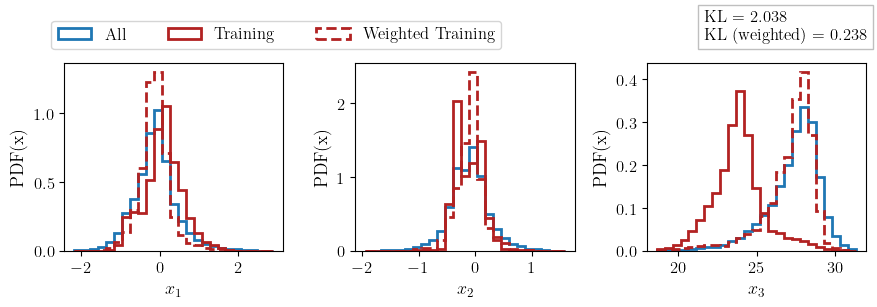

In [26]:
Fig, Ax = plt.subplots(1,3, figsize=(9,3))

Ax = Ax.flatten()

for i, ax in enumerate(Ax):

    c, bins, _ = ax.hist(X_pop[:,i], density=True, bins=25, 
                      range=np.percentile(X_pop[:,i], [0.1, 99.9]), histtype='step', lw=2,
                        label='All')
    useLatex()
    plt.rcParams.update({"font.size":12})
    ax.hist(X_train[:,i], density=True, bins=bins, histtype='step', lw=2, color='firebrick',
            label='Training')
    ax.hist(X_train[:,i], density=True, bins=bins, histtype='step', lw=2, color='firebrick', 
            ls='--', weights=weights,
            label='Weighted Training')
    
    ax.set_ylabel('PDF(x)',fontsize=13)
    ax.set_xlabel(f'$x_{i+1}$',fontsize=13)
kl = kl_score(X_pop, X_train, weights=weights, nbins=25, min_pct=0.1, max_pct=99.9)

#Ax[1].text(25,0.35,f'KL = {kl[0]:.3f}',fontsize=8)

#Ax[1].legend(frameon=True,loc='lower center',ncol=3,bbox_to_anchor=(0.5,1.05,2,1.05))
s = Fig.subplotpars

#Fig.text(0.7, 0.92,f'KL (weighted) = {kl[1]:.3f} ',bbox=dict(facecolor='none', edgecolor='red'))
Fig.text(0.8, 0.92,f'KL = {kl[0]:.3f} \n KL (weighted) = {kl[1]:.3f} ',
         bbox=dict(facecolor='none', edgecolor='grey',alpha =0.5))


bb=[s.left-0.05, s.top+0.05, 0.5, 0.05 ]
leg = Ax[0].legend(loc='upper center', bbox_to_anchor=bb, ncol= 3, mode="expand", borderaxespad=0,
                bbox_transform=Fig.transFigure)
#plt.subplots_adjust(wspace=0,hspace=0)
Fig.tight_layout()
plt.savefig(f'MPhys/gmm_files/feature_permutations/plots/pdf_f435w_base.pdf',bbox_inches='tight')

Although not perfect, we can see that the fainter training sources have been significantly up-weighted when compared to the original distribution. The colours are also distributed more like those of the full sample.

To include the weights in GPz we can simply add them to our input catalogue and tell GPz to include them in the training:

In [27]:
catalogue['weights'] = weights # Add the weights to our previous catalogue

weights_run, paths = test.run_training( # All of these as above but with minor changes
      catalogue, 
      outdir=directory, 
      basename=f'weighted_f435w_all_mags', # Change the prefix to keep separate
      bash_script=False,
      mag_prefix='lupt_',
      error_prefix='lupterr_', 
      id_col='id',
      total_basis_functions=n,
      do_iteration=False, 
      max_output = 16,
      verbose=False,
      weight_col='weights', # Now weight training by this column
    )

<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


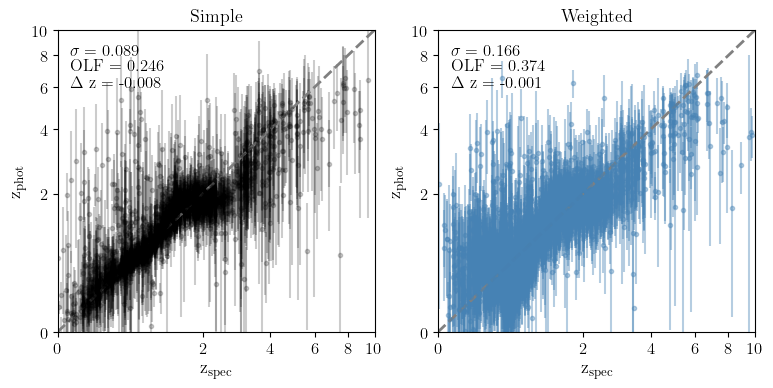

In [28]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))
useLatex()
plt.rcParams.update({"font.size":12})
Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(weights_run['z_spec'], weights_run['value'], 
            yerr=weights_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['Simple', 'Weighted']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_weight = calcStats(weights_run['z_spec'], weights_run['value'])

stats = [stats_simple, stats_weight]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])
    
    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 10], [0, 10], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$\text{z}_{\text{spec}}$',fontsize=13)
    ax.set_ylabel(r'$\text{z}_{\text{phot}}$',fontsize=13)
    ax.set_title(labels[i], size=13)
    #simple_sig = stats[0][0]
    #simple_olf = stats[0][2]
    #weighted_sig = stats[1][0]
    #weighted_olf = stats[1][2]
    ax.text(0.1, 8.0, f'$\sigma = $ {stats[i][0]:.3f}')
    ax.text(0.1, 7.0, f'OLF = {stats[i][2]:.3f}')
    ax.text(0.1, 6.0, f'$\Delta$ z = {stats[i][3]:.3f}')

plt.savefig(f'MPhys/gmm_files/feature_permutations/plots/csl_vs_simple_f435w_all_mags.pdf',bbox_inches='tight')

At face value, the weights have not resulted in an overall statistical improvement to the photo-$z$ estimates. But by eye, there is definitely some improvement at the higher redshift end. For now, we move onto the GMM-Divide option.

## GMM Divide

Dividing the training sample into different mixtures is as equally simple. For this example with its relatively small sample sizes, the number of training sources that could end up assigned to a mixture could be very small. We therefore will lower the threshold above which a source will be assigned to a mixture to 0.2, approximately saying that the source has at least a 20% chance of belonging to that mixture. (Note the default 0.5 effectively assigns each source to its best match)

In [29]:
train_mixtures = gmm.divide(X_train[:,:], 
                            weight=False, # Do not include CSL weights yet
                            threshold=0.1) # Change the divide threshold

train['weights'] = 1. # Re-set the weights to be equal

# Save for later
train_mixtures.write(f'f435w_mixtures_ex_all_mags_new1.csv', format='ascii.csv', overwrite=True)

In [30]:
gmm_output = Table.read('f435w_mixtures_ex_all_mags_new1.csv', format='ascii.csv')

divide_run, paths = test.run_training(catalogue, outdir=directory, 
                         basename=f'f435w_divide_all_mags1',
                         gmm_output=gmm_output,
                         bash_script=False,
                         weight_col='weights',
                         mag_prefix='lupt_', 
                         max_output=16,
                         error_prefix='lupterr_', id_col='id',
                         total_basis_functions=n, do_iteration=False, verbose=False)

GPz++ Run (mixture 4/4): 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


As above, lets compare the results between the simple and GMM divided runs:

<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


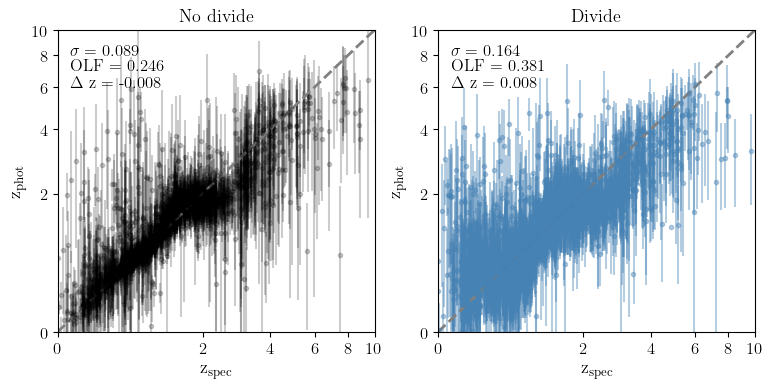

In [31]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))
useLatex()
plt.rcParams.update({"font.size":13})
Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(divide_run['z_spec'], divide_run['value'], 
            yerr=divide_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['No divide', 'Divide']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_divide = calcStats(divide_run['z_spec'], divide_run['value'])

stats = [stats_simple, stats_divide]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 10], [0, 10], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$\text{z}_{\text{spec}}$',fontsize=13)
    ax.set_ylabel(r'$\text{z}_{\text{phot}}$',fontsize=13)
    ax.set_title(labels[i], size=13)

    
   
    ax.text(0.1, 8.0, f'$\sigma = $ {stats[i][0]:.3f}',fontsize=12)
    ax.text(0.1, 7.0, f'OLF = {stats[i][2]:.3f}',fontsize=12)   
    ax.text(0.1, 6.0, f'$\Delta$ z = {stats[i][3]:.3f}',fontsize=12)
divide_sig = stats[1][0]
divide_olf = stats[1][2]



plt.savefig(f'MPhys/gmm_files/feature_permutations/plots/divide_f435w_all_mags.pdf',bbox_inches='tight')

This time we can see that overall outlier fraction and scatter are now improved. Visually, we can also see that the high-redshift end is also significantly improved. 

Lets now do a run using both the GMM Divide and Weights. This can be done using the divide option, but setting `weight = True` in the options. To prevent confusion, we will also now remove the weight column we added above, since the weights will now be propagated through the catalogue included as `gmm_output`:

In [32]:
train_mixtures2 = gmm.divide(X_train[:,:], 
                            weight=True,
                            threshold=0.5) # Do not include CSL weights yet

if 'weights' in train.colnames:
    train.remove_columns(['weights'])  # Weights will be taken from the GMM outputs file now instead

Run the gpz training as normal:

In [35]:
combined_run, paths = test.run_training(catalogue, outdir=directory,
                         basename=f'f435w_both_all_mags',
                         gmm_output=train_mixtures2,
                         bash_script=False,
                         weight_col='weights',
                         mag_prefix='lupt_', 
                         max_output = 16,
                         error_prefix='lupterr_', id_col='id',
                         total_basis_functions=n, do_iteration=False, verbose=False)

GPz++ Run (mixture 4/4): 100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)
<ipython-input-15-9ec618c62b3b>:3: RuntimeWarning: invalid value encountered in log10
  return np.log10(1+x)


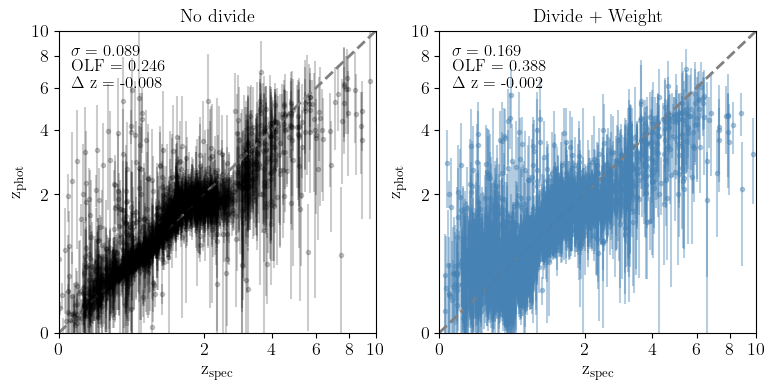

In [36]:
Fig, Ax = plt.subplots(1,2,figsize=(9,4))
useLatex()
plt.rcParams.update({"font.size":13})
Ax[0].errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], 
            fmt='o', ms=3, color='k', ecolor='k', alpha=0.2)

Ax[1].errorbar(combined_run['z_spec'], combined_run['value'], 
            yerr=combined_run['uncertainty'], 
            fmt='o', ms=3, color='steelblue', ecolor='steelblue', alpha=0.4)

labels = ['No divide', 'Divide + Weight']

stats_simple = calcStats(simple_run['z_spec'], simple_run['value'])
stats_combined = calcStats(combined_run['z_spec'], combined_run['value'])

stats = [stats_simple, stats_combined]

for i, ax in enumerate(Ax):
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))
    ax.plot([0, 10], [0, 10], '--', color='0.5', lw=2)
    ax.set_xlabel(r'$\text{z}_{\text{spec}}$',fontsize=13)
    ax.set_ylabel(r'$\text{z}_{\text{phot}}$',fontsize=13)
    ax.set_title(labels[i], size=13)
    
    ax.text(0.1, 8.0, f'$\sigma = $ {stats[i][0]:.3f}',fontsize=12)
    ax.text(0.1, 7.0, f'OLF = {stats[i][2]:.3f}',fontsize=12)
    ax.text(0.1, 6.0, f'$\Delta$ z = {stats[i][3]:.3f}',fontsize=12)
plt.savefig(f'MPhys/gmm_files/feature_permutations/plots/divide_weight_f435w_all_mags.png',bbox_inches='tight')

Compared to the Divide-only run, our combined Divide+Weights is performing slightly worse for the two metrics we have chosen, but is still an improvement over the Weight-only option. So in this case, using only the GMM-Divide would be the optimal approach. But as training sample sizes increase and additional features are added to the GPz training, this might not remain the case.

Additionally, since the spectroscopic sample is obviously biased, the Weight/Divide+Weight runs might actually provide better statistics for the overall galaxy population (at the expense of the brigher sources). Assessing the statistics as a function of e.g. spectroscopic redshift or magnitude can start to make these assessments clearer.

#Make a text file to compile stats into 
file = open(f'{directory}/stats_file_sigma.txt', 'a')
f = open(f'{directory}/stats_file_olf.txt', 'a')
#f.write('nbf,simple,weighted,divide,both')
#file.write('nbf,simple,weighted,divide,both')